<a href="https://colab.research.google.com/github/Kkordik/CrowdAware_Transit/blob/main/UPPER_Hackathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Plan:
- define routes and stops
- generate dataset
- guess exit stops
- time series calc
- final app

Code and idea license: apache-2.0

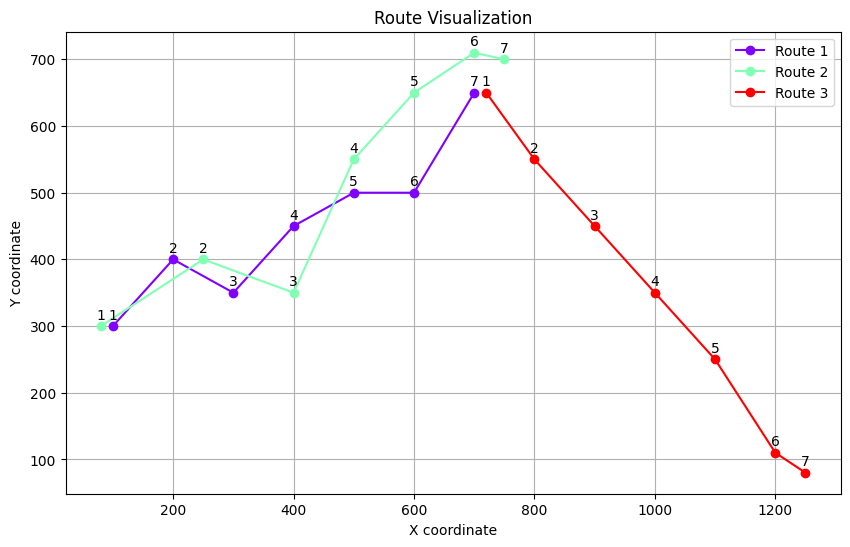

In [ ]:
#@title define routes and stops
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

routes = {
    1: pd.DataFrame({
        'stop_id':  [1, 2, 3, 4, 5, 6, 7],
        'x': [100, 200, 300, 400, 500, 600, 700],
        'y': [300, 400, 350, 450, 500, 500, 650],
    }),
    2: pd.DataFrame({
        'stop_id':  [1, 2, 3, 4, 5, 6, 7],
        'x': [80, 250, 400, 500, 600, 700, 750],
        'y': [300, 400, 350, 550, 650, 710, 700],
    }),
    3: pd.DataFrame({
        'stop_id': [1, 2, 3, 4, 5, 6, 7],
        'x': [720, 800, 900, 1000, 1100, 1200, 1250],
        'y': [650, 550, 450, 350, 250, 110, 80],
    })
}

# Create a plot
plt.figure(figsize=(10, 6))
colors = iter(cm.rainbow(np.linspace(0, 1, len(routes))))

for route_i in routes:
  # Plot route
  color = next(colors)
  plt.plot(routes[route_i]['x'], routes[route_i]['y'], 'o-', label=f'Route {route_i}', color=color)
  # Annotate route stops
  for idx, row in routes[route_i].iterrows():
      plt.annotate(f"{row['stop_id']}", (row['x'], row['y']), textcoords="offset points", xytext=(0,5), ha='center', color='black')

# Add title and labels
plt.title('Route Visualization')
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')

# Add a legend
plt.legend()

# Show the plot
plt.grid(True)
plt.show()


In [ ]:
#@title Add drive time
speed = 30 # @param {type:"slider", min:10, max:50, step:1}

def add_drive_time(routes, speed):
    routes_with_time = {}

    for route_id, route_df in routes.items():
        # Calculate distance between consecutive stops
        route_df['distance'] = np.sqrt((route_df['x'].diff() ** 2) + (route_df['y'].diff() ** 2))

        # Calculate drive time based on distance and speed
        route_df['drive_time'] = route_df['distance'] / speed

        # Fill NaN values (for the first stop)
        route_df['drive_time'].fillna(0, inplace=True)

        routes_with_time[route_id] = route_df

    return routes_with_time

# Add drive time to the routes
routes_with_time = add_drive_time(routes, speed)

# Print the routes with drive time
for route_id, route_df in routes_with_time.items():
    print(f"Route {route_id}:")
    print(route_df)
    print()

Route 1:
   stop_id    x    y    distance  drive_time
0        1  100  300         NaN    0.000000
1        2  200  400  141.421356    4.714045
2        3  300  350  111.803399    3.726780
3        4  400  450  141.421356    4.714045
4        5  500  500  111.803399    3.726780
5        6  600  500  100.000000    3.333333
6        7  700  650  180.277564    6.009252

Route 2:
   stop_id    x    y    distance  drive_time
0        1   80  300         NaN    0.000000
1        2  250  400  197.230829    6.574361
2        3  400  350  158.113883    5.270463
3        4  500  550  223.606798    7.453560
4        5  600  650  141.421356    4.714045
5        6  700  710  116.619038    3.887301
6        7  750  700   50.990195    1.699673

Route 3:
   stop_id     x    y    distance  drive_time
0        1   720  650         NaN    0.000000
1        2   800  550  128.062485    4.268749
2        3   900  450  141.421356    4.714045
3        4  1000  350  141.421356    4.714045
4        5  1100  250

In [ ]:
#@title generate dataset

import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import random

def generate_passenger_traffic(num_passengers, num_days, routes):
    data = []

    for passenger_id in range(1, num_passengers + 1):
        for day in range(num_days):
            # Determine if the passenger makes one or two trips
            makes_return_trip = random.random() < 0.7  # 70% chance to make a return trip
            # Morning trip
            morning_route = random.choice([1, 2])
            morning_direction = random.choice([1, -1])
            morning_stops = routes[morning_route]['stop_id'].tolist()
            if morning_direction == -1:
                morning_stops.reverse()
            morning_stop = random.choice(morning_stops)
            morning_time = datetime(2024, 1, 1) + timedelta(days=day, hours=random.randint(6, 9))

            data.append({
                'passenger_id': passenger_id,
                'time_of_entering': morning_time,
                'direction': morning_direction,
                'route_id': morning_route,
                'stop_id': morning_stop
            })

            if makes_return_trip:
                # Evening trip
                evening_route = morning_route if random.random() < 0.5 else 3
                evening_direction = -morning_direction
                evening_stops = routes[evening_route]['stop_id'].tolist()
                if evening_direction == -1:
                    evening_stops.reverse()
                evening_stop = random.choice(evening_stops)
                evening_time = morning_time + timedelta(hours=random.randint(9, 12))

                data.append({
                    'passenger_id': passenger_id,
                    'time_of_entering': evening_time,
                    'direction': evening_direction,
                    'route_id': evening_route,
                    'stop_id': evening_stop
                })

                # Route change scenario (e.g., from Route 1 to Route 3)
                if morning_route != 3 and random.random() < 0.3:  # 30% chance of changing route
                    change_route = 3
                    change_direction = random.choice([1, -1])
                    change_stops = routes[change_route]['stop_id'].tolist()
                    if change_direction == -1:
                        change_stops.reverse()
                    change_stop = random.choice(change_stops)
                    change_time = morning_time + timedelta(hours=random.randint(1, 3))

                    data.append({
                        'passenger_id': passenger_id,
                        'time_of_entering': change_time,
                        'direction': change_direction,
                        'route_id': change_route,
                        'stop_id': change_stop
                    })

    df = pd.DataFrame(data)
    return df

# Generate a dataset
num_days = 30  # Whole month
traffic_data = generate_passenger_traffic(num_passengers=100, num_days=num_days, routes=routes)
print(traffic_data.head())


   passenger_id    time_of_entering  direction  route_id  stop_id
0             1 2024-01-01 08:00:00          1         2        3
1             1 2024-01-01 19:00:00         -1         2        7
2             1 2024-01-01 11:00:00          1         3        5
3             1 2024-01-02 07:00:00          1         1        2
4             1 2024-01-02 19:00:00         -1         1        4


In [ ]:
#@title visualize the dataset
def plot_passenger_count_over_time(df):
    df['hour'] = df['time_of_entering'].dt.hour
    passenger_count = df.groupby('hour').size()

    plt.figure(figsize=(12, 6))
    passenger_count.plot(kind='bar')
    plt.title('Passenger Count Over Time')
    plt.xlabel('Hour of Day')
    plt.ylabel('Number of Passengers')
    plt.grid(True)
    plt.show()

plot_passenger_count_over_time(traffic_data)


In [ ]:
#@ guess exit stops
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import random
from scipy.spatial import distance

# Helper functions
def calculate_unit_vector(route, direction):
    route_coords = route[['x', 'y']].diff().iloc[1:]
    route_vectors = route_coords.values * direction
    magnitudes = np.linalg.norm(route_vectors, axis=1).reshape(-1, 1)
    unit_vectors = route_vectors / magnitudes
    return unit_vectors

def angle_between_vectors(v1, v2):
    dot_product = np.dot(v1, v2)
    norms = np.linalg.norm(v1) * np.linalg.norm(v2)
    if norms == 0:
        return 0  # Handles the case when either vector has zero length
    elif dot_product / norms > 1:
        return 0  # Handles cases when dot_product / norms > 1 due to floating-point errors
    elif dot_product / norms < -1:
        return np.pi  # Handles cases when dot_product / norms < -1 due to floating-point errors
    else:
        return np.arccos(dot_product / norms)

def closest_stop(route, coord):
    route_coords = route[['x', 'y']].values
    distances = distance.cdist([coord], route_coords, 'euclidean')
    closest_index = np.argmin(distances)
    return route.iloc[closest_index]['stop_id']

def infer_drop_off(df, routes):
    complete_trips = []

    for passenger_id, trips in df.groupby('passenger_id'):
        trips = trips.sort_values('time_of_entering').reset_index(drop=True)
        range_iter = iter(range(len(trips) - 1))
        for i in range_iter:
          try:
              trip1 = trips.iloc[i]
              trip2 = trips.iloc[i + 1]

              route1 = routes[trip1['route_id']]
              route2 = routes[trip2['route_id']]

              unit_vectors1 = calculate_unit_vector(route1, trip1['direction'])
              unit_vectors2 = calculate_unit_vector(route2, trip2['direction'])

              stop1_idx = route1[route1['stop_id'] == trip1['stop_id']].index[0]
              stop2_idx = route2[route2['stop_id'] == trip2['stop_id']].index[0]

              if stop1_idx < len(unit_vectors1):
                  vec1 = unit_vectors1[stop1_idx]
              else:
                  continue

              if stop2_idx < len(unit_vectors2):
                  vec2 = unit_vectors2[stop2_idx]
              else:
                  continue

              angle = angle_between_vectors(vec1, vec2)

              if angle > 2 * np.pi / 3:  # Returning trip
                  if trip1['route_id'] == trip2['route_id']:
                      if trip1['stop_id'] < trip2['stop_id']:
                          total_drive_time1 = route1.loc[trip1['stop_id']:trip2['stop_id'], 'drive_time'].sum()
                      else:
                          total_drive_time1 = route1.loc[trip2['stop_id']:trip1['stop_id'], 'drive_time'].sum()

                      if trip2['stop_id'] < trip1['stop_id']:
                          total_drive_time2 = route2.loc[trip2['stop_id']:trip1['stop_id'], 'drive_time'].sum()
                      else:
                          total_drive_time2 = route2.loc[trip1['stop_id']:trip2['stop_id'], 'drive_time'].sum()
                      print(f"total_drive_time1: {total_drive_time1},  total_drive_time2: {total_drive_time2}, {pd.to_timedelta(total_drive_time1, unit='m')},  {pd.to_timedelta(total_drive_time2, unit='m')}")
                      complete_trips.append({
                          'passenger_id': passenger_id,
                          'route_id': trip1['route_id'],
                          'direction': trip1['direction'],
                          'start_stop': trip1['stop_id'],
                          'finish_stop': trip2['stop_id'],
                          'time_of_entering': trip1['time_of_entering'],
                          'time_of_exiting': trip1['time_of_entering'] + pd.to_timedelta(total_drive_time1, unit='h'),
                          'trip_type': 'commute'
                      })
                      complete_trips.append({
                          'passenger_id': passenger_id,
                          'route_id': trip1['route_id'],
                          'direction': trip2['direction'],
                          'start_stop': trip2['stop_id'],
                          'finish_stop': trip1['stop_id'],
                          'time_of_entering': trip2['time_of_entering'],
                          'time_of_exiting': trip2['time_of_entering'] + pd.to_timedelta(total_drive_time2, unit='h'),
                          'trip_type': 'return'
                      })
                      next(range_iter)
                  else:  # Returning on a different route
                      morning_coord = route1[route1['stop_id'] == trip1['stop_id']][['x', 'y']].values[0]
                      evening_stop_off = closest_stop(route2, morning_coord)
                      evening_coord = route2[route2['stop_id'] == trip2['stop_id']][['x', 'y']].values[0]
                      morning_stop_off = closest_stop(route1, evening_coord)

                      if trip1['stop_id'] < morning_stop_off:
                          total_drive_time1 = route1.loc[trip1['stop_id']:morning_stop_off, 'drive_time'].sum()
                      else:
                          total_drive_time1 = route1.loc[morning_stop_off:trip1['stop_id'], 'drive_time'].sum()

                      if trip2['stop_id'] < evening_stop_off:
                          total_drive_time2 = route2.loc[trip2['stop_id']:evening_stop_off, 'drive_time'].sum()
                      else:
                          total_drive_time2 = route2.loc[evening_stop_off:trip2['stop_id'], 'drive_time'].sum()

                      complete_trips.append({
                          'passenger_id': passenger_id,
                          'route_id': trip1['route_id'],
                          'direction': trip1['direction'],
                          'start_stop': trip1['stop_id'],
                          'finish_stop': morning_stop_off,
                          'time_of_entering': trip1['time_of_entering'],
                          'time_of_exiting': trip1['time_of_entering'] + pd.to_timedelta(total_drive_time1, unit='h'),
                          'trip_type': 'commute_different_route'
                      })
                      complete_trips.append({
                          'passenger_id': passenger_id,
                          'route_id': trip2['route_id'],
                          'direction': trip2['direction'],
                          'start_stop': trip2['stop_id'],
                          'finish_stop': evening_stop_off,
                          'time_of_entering': trip2['time_of_entering'],
                          'time_of_exiting': trip2['time_of_entering'] + pd.to_timedelta(total_drive_time2, unit='h'),
                          'trip_type': 'return_different_route'
                      })
                      next(range_iter)
              else:  # Potential route change or continuation
                  time_diff = (trip2['time_of_entering'] - trip1['time_of_entering']).total_seconds() / 3600.0
                  if time_diff <= 1.0:  # Route change if the time difference is small
                      if trip1['stop_id'] < trip2['stop_id']:
                          total_drive_time = route1.loc[trip1['stop_id']:trip2['stop_id'], 'drive_time'].sum()
                      else:
                          total_drive_time = route1.loc[trip2['stop_id']:trip1['stop_id'], 'drive_time'].sum()
                      complete_trips.append({
                          'passenger_id': passenger_id,
                          'route_id': trip1['route_id'],
                          'direction': trip2['direction'],
                          'start_stop': trip1['stop_id'],
                          'finish_stop': trip2['stop_id'],
                          'time_of_entering': trip1['time_of_entering'],
                          'time_of_exiting': trip1['time_of_entering'] + pd.to_timedelta(total_drive_time, unit='h'),
                          'trip_type': 'route_change'
                      })
                  else:  # Consider as separate trip
                      complete_trips.append({
                          'passenger_id': passenger_id,
                          'route_id': trip1['route_id'],
                          'direction': trip2['direction'],
                          'start_stop': trip1['stop_id'],
                          'finish_stop': None,
                          'time_of_entering': trip1['time_of_entering'],
                          'time_of_exiting': None,  # Set time_of_exiting as None for separate trip
                          'trip_type': 'separate_trip'
                      })
          except StopIteration:
            # Handle the case when there are no more trips to process
            break

    return pd.DataFrame(complete_trips)


# Infer the drop-off locations and trip types
complete_trips_df = infer_drop_off(traffic_data, routes_with_time)
print(complete_trips_df.head())


In [ ]:
def plot_trip_types(complete_trips_df):
    trip_type_counts = complete_trips_df['trip_type'].value_counts()

    plt.figure(figsize=(8, 6))
    trip_type_counts.plot(kind='bar', color='skyblue')
    plt.title('Distribution of Trip Types')
    plt.xlabel('Trip Type')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

plot_trip_types(complete_trips_df)


In [ ]:
def adjust_dataframe(df):
    # Filter out separate trips
    commute_trips = df[df['trip_type'] != 'separate_trip'].copy()

    # Get counts of commute trips by passenger
    trip_counts = commute_trips['passenger_id'].value_counts().reset_index()
    trip_counts.columns = ['passenger_id', 'trip_count']

    # Merge trip counts back to the commute trips dataframe
    commute_trips = pd.merge(commute_trips, trip_counts, on='passenger_id', how='left')

    # Adjust time_of_entering column by adding timedelta
    commute_trips['time_of_entering'] += pd.to_timedelta(commute_trips['trip_count'], unit='h')

    # Drop duplicated rows
    commute_trips.drop_duplicates(inplace=True)

    # Drop the trip_count column
    commute_trips.drop(columns=['trip_count'], inplace=True)

    return commute_trips

# Adjust the DataFrame
adjusted_df = adjust_dataframe(complete_trips_df)
print(adjusted_df.head())


In [ ]:
plot_trip_types(adjusted_df)

# Predicting

In [ ]:
!git clone https://github.com/time-series-foundation-models/lag-llama/
%cd /content/lag-llama
!pip install -r requirements.txt --quiet # this could take some time # ignore the errors displayed by colab
!huggingface-cli download time-series-foundation-models/Lag-Llama lag-llama.ckpt --local-dir /content/lag-llama
!pip install gluonts==0.14.4

In [ ]:
from itertools import islice

from matplotlib import pyplot as plt
import matplotlib.dates as mdates

import torch
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.repository.datasets import get_dataset

from gluonts.dataset.pandas import PandasDataset
import pandas as pd

from lag_llama.gluon.estimator import LagLlamaEstimator

# Lag-Llama prediction function

In [ ]:
def get_lag_llama_predictions(dataset, prediction_length, device, context_length=32, use_rope_scaling=False, num_samples=100):
    ckpt = torch.load("lag-llama.ckpt", map_location=device) # Uses GPU since in this Colab we use a GPU.
    estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

    rope_scaling_arguments = {
        "type": "linear",
        "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
    }

    estimator = LagLlamaEstimator(
        ckpt_path="lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=context_length, # Lag-Llama was trained with a context length of 32, but can work with any context length

        # estimator args
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        scaling=estimator_args["scaling"],
        time_feat=estimator_args["time_feat"],
        rope_scaling=rope_scaling_arguments if use_rope_scaling else None,

        batch_size=1,
        num_parallel_samples=100,
        device=device,
    )

    lightning_module = estimator.create_lightning_module()
    transformation = estimator.create_transformation()
    predictor = estimator.create_predictor(transformation, lightning_module)

    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset,
        predictor=predictor,
        num_samples=num_samples
    )
    forecasts = list(forecast_it)
    tss = list(ts_it)

    return forecasts, tss

In [ ]:
import pandas as pd
from datetime import timedelta

def predict_passenger_count(complete_trips, route_id, stop_id, direction, prediction_horizon_hours=1):
    # Filter the complete_trips dataframe based on route, stop, and direction
    filtered_trips = complete_trips[(complete_trips['route_id'] == route_id) &
                                     (complete_trips['start_stop'] == stop_id) &
                                     (complete_trips['direction'] == direction)]

    # Determine the relevant time window for prediction
    print(filtered_trips)
    prediction_window_start = filtered_trips['time_of_entering'].min()
    prediction_window_end = prediction_window_start + timedelta(hours=prediction_horizon_hours)

    # Create time intervals for prediction
    prediction_intervals = pd.date_range(start=prediction_window_start, end=prediction_window_end, freq='30T')

    # Count the number of entered passengers for each 30-minute interval
    passenger_counts = []
    for interval_start, interval_end in zip(prediction_intervals[:-1], prediction_intervals[1:]):
        passengers_entered = ((filtered_trips['time_of_entering'] >= interval_start) &
                              (filtered_trips['time_of_entering'] < interval_end)).sum()
        passenger_counts.append(passengers_entered)

    return passenger_counts

# Example usage
print(adjusted_df)
passenger_counts = predict_passenger_count(adjusted_df, route_id=2, stop_id=5, direction=1, prediction_horizon_hours=1)
print("Predicted number of passengers for each 30-minute interval:", passenger_counts)


In [ ]:
import pandas as pd
import numpy as np
import torch
from gluonts.dataset.pandas import PandasDataset

def predict_passenger_count(complete_trips, route_id, stop_id, direction, prediction_length=24):
    # Filter trips for the specific route, stop, and direction
    filtered_trips = complete_trips[(complete_trips['route_id'] == route_id) &
                                     (complete_trips['start_stop'] == stop_id) &
                                     (complete_trips['direction'] == direction)]

    # Convert 'time_of_entering' to datetime
    filtered_trips['time_of_entering'] = pd.to_datetime(filtered_trips['time_of_entering'])

    # Create a new DataFrame to store passenger counts in 30-minute intervals
    min_time = filtered_trips['time_of_entering'].min().floor('30T')
    max_time = filtered_trips['time_of_entering'].max().ceil('30T')
    time_index = pd.date_range(start=min_time, end=max_time, freq='30T')
    passenger_counts = pd.DataFrame(index=time_index, columns=['count']).fillna(0)

    # Manually count passengers in each 30-minute interval
    for time in time_index:
        count = len(filtered_trips[(filtered_trips['time_of_entering'] >= time) &
                                   (filtered_trips['time_of_entering'] < time + pd.Timedelta('30T'))])
        passenger_counts.at[time, 'count'] = count

    # Prepare the dataset for Lag-Llama
    df = passenger_counts.reset_index()
    df.columns = ['timestamp', 'target']
    df['target'] = df['target'].astype('float32')
    df['item_id'] = 1  # Adding a dummy item_id

    # Create the PandasDataset
    dataset = PandasDataset.from_long_dataframe(df, target="target", timestamp="timestamp", item_id="item_id")

    # Set the device for Lag-Llama
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Get Lag-Llama predictions
    forecasts, tss = get_lag_llama_predictions(dataset, prediction_length, device)

    return forecasts, tss

# Example usage:
forecasts, tss = predict_passenger_count(adjusted_df, route_id=2, stop_id=4, direction='north', prediction_length=24)
